Hi Alex, First of all, I want to say thank you for giving me an opportunity to perform your work.
In this tutorial, I will present a few simple yet effective methods that we can use to build a powerful image classifier for your dataset.

We will go over the following options: 
    1. training a small network from scratch (as a baseline)
    2. fine-tuning the top layers of a pre-trained network

Let’s discuss how to train model from scratch and classify the data containing six classes.


For feeding the dataset folders the should be made and provided into this format only. So now, Let’s begins with importing libraries.

In [1]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.callbacks import TensorBoard
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/poudelas/anaco

We use the TensorBoard visualization method in order to check the training and validation process. Here, the DATASET_PATH is the root dataset directory where it contains train and test folders. Every image in the dataset is of the size of 224*224. We set the batch size of 8 depending upon the computing capacity of GPU.


In [2]:
tensorboard = TensorBoard(log_dir='./ScratchNetwork',histogram_freq=0,write_graph=True,write_images=False)
DATASET_PATH = '/home/poudelas/Documents/Alex/'
IMAGE_SIZE    = (112, 112)
NUM_CLASSES   = 5
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    =20
WEIGHTS_FINAL = 'ScratchNetwork.h5'

# Preparation of the Data

1. ImageDataGenerator includes all possible orientation of the image. we set the preprocessing function done by the default ResNet50 model. All kind of augmentation like shearing, flipping, rotation can be included here if needed.
2. train_datagen.flow_from_directory is the function that is used to prepare data from the train_dataset directory Target_size specifies the target size of the image.
3. valid_datagen.flow_from_directory is used to prepare validation data for the model and all is similar as above.



In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    featurewise_center=True,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True
                                       )
train_batches = train_datagen.flow_from_directory(DATASET_PATH + 'train/seg_train',
                                                      target_size=IMAGE_SIZE,
                                                      class_mode='categorical',
                                                      classes=['buildings', 'forest',
                                                               'glacier', 'mountain', 'sea','street'],
                                                      batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + 'test/seg_test',
                                                          target_size=IMAGE_SIZE,
                                                          class_mode='categorical',
                                                          classes=['buildings', 'forest',
                                                               'glacier', 'mountain', 'sea','street'],
                                                          shuffle=False,
                                                          batch_size=BATCH_SIZE)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [4]:


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(112, 112, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 53, 53, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)      

 Keypoint Takenaways
 1. Conv2D is the layer to convolve the image into multiple images.
 2. MaxPooling2D is used to max pool the value from the given size matrix and same is used for the next 2 layers.
 3. Dense is the output layer contains neurons which decide to which category image belongs.

We end the model with a softmax activation which will produce probability score for six class, i.e. called multi-class classification. Therefore, we will also use the categorical_crossentropy loss to train our model. If the model has just 2 output in softmax activation function, then binary_crossentropy loss function can be used.

In [24]:
model.compile(SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


In [25]:
H = model.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = NUM_EPOCHS,
                            workers=8,
                            callbacks=[tensorboard]
                            )
model.save(WEIGHTS_FINAL)

Epoch 1/20
   1/1754 [..............................] - ETA: 5:51 - loss: 10.4149 - acc: 0.1250

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1754/1754 [==============================] - 16s 9ms/step - loss: 1.3159 - acc: 0.5309 - val_loss: 1.0142 - val_acc: 0.6270
Epoch 2/20
1754/1754 [==============================] - 17s 10ms/step - loss: 1.0179 - acc: 0.6130 - val_loss: 1.2573 - val_acc: 0.5427
Epoch 3/20
1754/1754 [==============================] - 16s 9ms/step - loss: 0.9604 - acc: 0.6388 - val_loss: 1.1623 - val_acc: 0.6107
Epoch 4/20
1754/1754 [==============================] - 17s 9ms/step - loss: 0.9220 - acc: 0.6556 - val_loss: 0.8933 - val_acc: 0.6647
Epoch 5/20
1754/1754 [==============================] - 18s 10ms/step - loss: 0.8929 - acc: 0.6657 - val_loss: 0.8561 - val_acc: 0.7080
Epoch 6/20
1754/1754 [==============================] - 18s 10ms/step - loss: 0.8665 - acc: 0.6801 - val_loss: 0.8061 - val_acc: 0.7080
Epoch 7/20
1754/1754 [==============================] - 17s 10ms/step - loss: 0.8556 - acc: 0.6864 - val_loss: 0.8081 - val_acc: 0.7180
Epoch 8/20
1754/1754 [==============================] - 18s 10

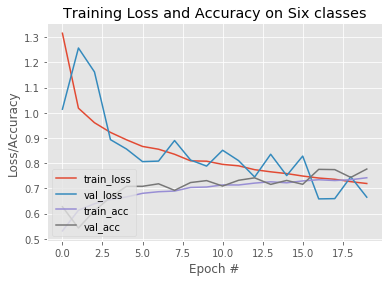

In [27]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Six classes")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Hi alex, when i used vey high learning rate, The model takes time to converge, since it have very training and testing loss. Therefore, i trained on 0.000001. It seems okay. It is observable that the training and validation accuracy is increasing. So it should be train for more epoch.

# 50 epoch

In [28]:
H = model.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = 50,
                            workers=8,
                            callbacks=[tensorboard]
                            )
model.save(WEIGHTS_FINAL)

Epoch 1/50
   9/1754 [..............................] - ETA: 34s - loss: 0.7894 - acc: 0.7361 

/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1754/1754 [==============================] - 16s 9ms/step - loss: 0.7227 - acc: 0.7393 - val_loss: 0.6505 - val_acc: 0.7807
Epoch 2/50
1754/1754 [==============================] - 16s 9ms/step - loss: 0.7031 - acc: 0.7502 - val_loss: 0.7220 - val_acc: 0.7543
Epoch 3/50
1754/1754 [==============================] - 16s 9ms/step - loss: 0.7042 - acc: 0.7432 - val_loss: 0.6694 - val_acc: 0.7757
Epoch 4/50
1754/1754 [==============================] - 16s 9ms/step - loss: 0.6974 - acc: 0.7444 - val_loss: 0.6747 - val_acc: 0.7713
Epoch 5/50
1754/1754 [==============================] - 17s 10ms/step - loss: 0.6896 - acc: 0.7532 - val_loss: 0.6720 - val_acc: 0.7717
Epoch 6/50
1754/1754 [==============================] - 17s 10ms/step - loss: 0.6898 - acc: 0.7566 - val_loss: 0.7040 - val_acc: 0.7670
Epoch 7/50
1754/1754 [==============================] - 17s 9ms/step - loss: 0.6790 - acc: 0.7546 - val_loss: 0.6469 - val_acc: 0.7833
Epoch 8/50
1754/1754 [==============================] - 17s 10ms

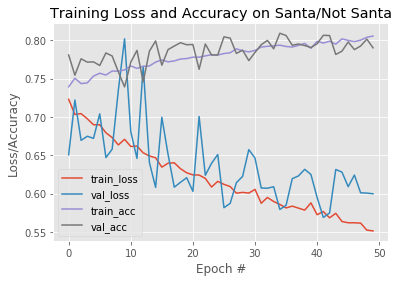

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on six classes")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


Ok , It seems good right. So we got around 80% with the scratch model. Oh, wait. So now i have a curiosity, what would happen if we train this model for more epoch with higher learning rate? Ok lets see.....

In [30]:
results = model.evaluate_generator(generator=valid_batches)
print('Testing loss:' + str(results[0]))
print('Testing Accuracy:' + str(results[1]*100))



Testing loss:0.5997346225666503
Testing Accuracy:79.0


# 100 epoch  with 0.001 learning rate.

In [5]:
model.compile(SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


In [6]:
H = model.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = 100,
                            workers=8,
                            callbacks=[tensorboard]
                            )
model.save(WEIGHTS_FINAL)

Epoch 1/100


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1754/1754 [==============================] - 20s 11ms/step - loss: 13.3540 - acc: 0.1713 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 2/100
1754/1754 [==============================] - 17s 10ms/step - loss: 13.3556 - acc: 0.1714 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 3/100
1754/1754 [==============================] - 17s 10ms/step - loss: 13.3567 - acc: 0.1713 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 4/100
1754/1754 [==============================] - 17s 10ms/step - loss: 13.3636 - acc: 0.1709 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 5/100
1754/1754 [==============================] - 17s 10ms/step - loss: 13.3567 - acc: 0.1713 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 6/100
1754/1754 [==============================] - 17s 10ms/step - loss: 13.3521 - acc: 0.1716 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 7/100
1754/1754 [==============================] - 17s 10ms/step - loss: 13.3659 - acc: 0.1708 - val_loss: 13.1470 - val_acc: 0.1843
Epoch 8/100
1754/1754 [================

KeyboardInterrupt: 

It doesn't seem improving. Therefore, there is no need for further training. So now i will switch to transfer learning.

In [8]:
# create the base pre-trained model
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
WEIGHTS_FINAL = 'ResNet.h5'

In [9]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)
print(model1.summary())



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [10]:
model1.compile(SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


In [11]:
H1 = model1.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = 100,
                            workers=8
                            )
model1.save(WEIGHTS_FINAL)

Epoch 1/100


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1754/1754 [==============================] - 91s 52ms/step - loss: 0.7344 - acc: 0.7377 - val_loss: 0.3809 - val_acc: 0.8670
Epoch 2/100
1754/1754 [==============================] - 88s 50ms/step - loss: 0.4656 - acc: 0.8330 - val_loss: 0.3006 - val_acc: 0.8993
Epoch 3/100
1754/1754 [==============================] - 88s 50ms/step - loss: 0.3989 - acc: 0.8599 - val_loss: 0.2746 - val_acc: 0.9067
Epoch 4/100
1754/1754 [==============================] - 87s 49ms/step - loss: 0.3670 - acc: 0.8728 - val_loss: 0.2525 - val_acc: 0.9110
Epoch 5/100
1754/1754 [==============================] - 86s 49ms/step - loss: 0.3384 - acc: 0.8781 - val_loss: 0.2593 - val_acc: 0.9150
Epoch 6/100
1754/1754 [==============================] - 87s 49ms/step - loss: 0.3202 - acc: 0.8883 - val_loss: 0.2647 - val_acc: 0.9113
Epoch 7/100
1754/1754 [==============================] - 86s 49ms/step - loss: 0.3009 - acc: 0.8927 - val_loss: 0.2377 - val_acc: 0.9187
Epoch 8/100
1754/1754 [==============================

KeyboardInterrupt: 

As  you can see, Training and validation accuracy is increasing very slowly. So i decided to increase learning rate and decrease epoch. I will set just 20 epoch. And that will be enough.


# 0.001 learning rate and 20 epoch

In [12]:
model1.compile(SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


In [13]:
H1 = model1.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = 20,
                            workers=8
                            )
model1.save(WEIGHTS_FINAL)

Epoch 1/20


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1754/1754 [==============================] - 91s 52ms/step - loss: 0.3984 - acc: 0.8601 - val_loss: 0.3603 - val_acc: 0.8767
Epoch 2/20
1754/1754 [==============================] - 87s 50ms/step - loss: 0.3125 - acc: 0.8875 - val_loss: 0.3215 - val_acc: 0.8993
Epoch 3/20
1754/1754 [==============================] - 87s 50ms/step - loss: 0.2804 - acc: 0.8987 - val_loss: 0.3595 - val_acc: 0.8943
Epoch 4/20
1754/1754 [==============================] - 87s 50ms/step - loss: 0.2488 - acc: 0.9126 - val_loss: 0.3578 - val_acc: 0.8920
Epoch 5/20
1754/1754 [==============================] - 87s 50ms/step - loss: 0.2378 - acc: 0.9161 - val_loss: 0.3248 - val_acc: 0.8963
Epoch 6/20
1754/1754 [==============================] - 87s 50ms/step - loss: 0.2145 - acc: 0.9225 - val_loss: 0.3565 - val_acc: 0.8983
Epoch 7/20
1754/1754 [==============================] - 87s 50ms/step - loss: 0.1975 - acc: 0.9289 - val_loss: 0.3791 - val_acc: 0.8857
Epoch 8/20
1754/1754 [==============================] - 87s

In [15]:
results = model1.evaluate_generator(generator=valid_batches)
print('Testing loss:' + str(results[0]))
print('Testing Accuracy:' + str(results[1]*100))



Testing loss:0.34066103872719533
Testing Accuracy:90.36666666666666


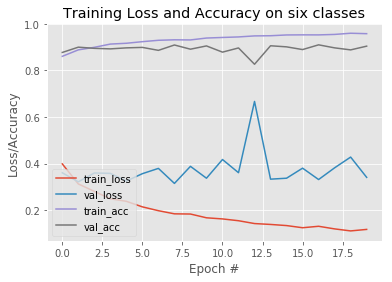

In [18]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0, N), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H1.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H1.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on six classes")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

HMM.....So Training the model on learning rate of 0.0001 was a good decision. The latest model is also not bad but it is overfitting. So training previous model could achieve above 95%.

# Okay, Lets train EfficientNet.

In [22]:
import efficientnet.keras as efn
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import LeakyReLU, Add, Input,MaxPool2D,UpSampling2D,concatenate,Conv2DTranspose,BatchNormalization,Dropout
efficient = efn.EfficientNetB0(weights='imagenet',include_top=False,input_shape=(112,112,3))

In [24]:
x = efficient.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer --  we have 5 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model2 = Model(inputs=efficient.input, outputs=predictions)
print(model2.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 56, 56, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 56, 56, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 56, 56, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [26]:
model2.compile(SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled!!!')

compiled!!!


In [29]:
WEIGHTS_FINAL = 'Efficientnet.h5'
H2 = model2.fit_generator(train_batches,
                            steps_per_epoch = train_batches.samples // BATCH_SIZE,
                            validation_data = valid_batches,
                            validation_steps=valid_batches.samples // BATCH_SIZE,
                            epochs = 20,
                            workers=8
                            )
model2.save(WEIGHTS_FINAL)



Epoch 1/20


/home/poudelas/anaconda3/envs/auto/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


1754/1754 [==============================] - 95s 54ms/step - loss: 0.7274 - acc: 0.7370 - val_loss: 0.3670 - val_acc: 0.8743
Epoch 2/20
1754/1754 [==============================] - 89s 51ms/step - loss: 0.4687 - acc: 0.8359 - val_loss: 0.3241 - val_acc: 0.8857
Epoch 3/20
1754/1754 [==============================] - 89s 51ms/step - loss: 0.4078 - acc: 0.8583 - val_loss: 0.2968 - val_acc: 0.8967
Epoch 4/20
1754/1754 [==============================] - 90s 51ms/step - loss: 0.3708 - acc: 0.8695 - val_loss: 0.2889 - val_acc: 0.8957
Epoch 5/20
1754/1754 [==============================] - 90s 51ms/step - loss: 0.3400 - acc: 0.8813 - val_loss: 0.2704 - val_acc: 0.9017
Epoch 6/20
1754/1754 [==============================] - 90s 51ms/step - loss: 0.3194 - acc: 0.8879 - val_loss: 0.2784 - val_acc: 0.9027
Epoch 7/20
1754/1754 [==============================] - 90s 51ms/step - loss: 0.2970 - acc: 0.8950 - val_loss: 0.2382 - val_acc: 0.9183
Epoch 8/20
1754/1754 [==============================] - 91s

375/375 [==============================] - 4s 11ms/step


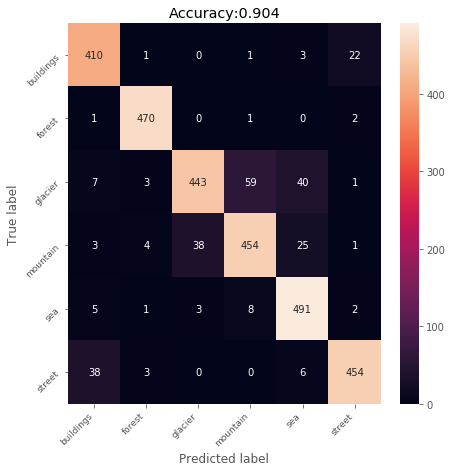

In [32]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score
import pandas as pd
import seaborn as sns

pred1=model2.predict_generator(valid_batches,verbose=1)
y_pred1 = np.argmax(pred1,axis=-1)
cm = confusion_matrix(valid_batches.classes, y_pred1)
cm_df = pd.DataFrame(cm,
                      index = ['buildings','forest','glacier','mountain','sea','street'],
                      columns = ['buildings','forest','glacier','mountain','sea','street'])

plt.figure(figsize=(7,7))
#sns.heatmap(cm_df, annot=True)
try:
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d")
except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=9)
plt.title('Accuracy:{0:.3f}'.format(results[1]))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

With confusion matrix, It can be seen that, the model is confused between buildings and street.

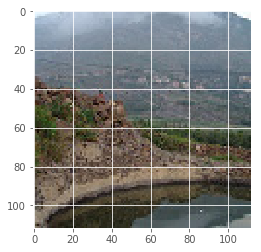

In [37]:
from keras.preprocessing import image

img_path = '/home/poudelas/20058.jpg'

# We preprocess the image into a 4D tensor
img = image.load_img(img_path, target_size=(112, 112))

img_tensor1 = np.expand_dims(img, axis=0)

img_tensor2 = preprocess_input(img_tensor1)
plt.imshow(img)
plt.show()
preds = model2.predict(img_tensor2)


In [35]:
np.argmax(preds[0])

3

Thank you Alex. I think , I have fulfilled all your requirements. I hope, You will provide another projects in near future. Good Bye.